In [22]:
import geopandas as gpd
vector = gpd.read_file('D://Hyderabad_tiff//building.shp')
vector.to_file('D://Hyderabad_tiff//clip//building_shp111.geojson',driver='GeoJSON')

C:\Users\Ankita.Digambar\Anaconda3\envs\Ankita.digambar\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [3]:
import rioxarray
import json
import glob
import rasterio as rio

tif_dir = 'D:\\Hyderabad_tiff\\Hyd_img.tif'
geojson_dir = 'D://Hyderabad_tiff//clip//building_shp111.geojson'

with open(geojson_dir) as gj:
    data = json.load(gj)
    
crs = data['crs']['properties']['name']
geo_mass = [feat['geometry'] for feat in data['features']]
rds = rioxarray.open_rasterio(tif_dir).isel(band=0)
rds.values[:] = 0
rds.rio.write_nodata(1, inplace = True)
clipped = rds.rio.clip(geo_mass, crs, drop= False)
clipped.rio.to_raster('D:\\Hyderabad_tiff\\mass_hyd\\mass_hyd_9.tif')

In [1]:
import geopandas as gpd
shapefile = 'D://Hyderabad_tiff//building.shp'
data = gpd.read_file(shapefile)
selection = data[0:5]
list_area =[]
for index, row in selection.iterrows():
    poly_area = row['geometry'].area
    list_area.append(poly_area)
    print("Polygon area at index {0} is: {1:.3f} squareM".format(index, poly_area))  


Polygon area at index 0 is: 1140.459 squareM
Polygon area at index 1 is: 229.018 squareM
Polygon area at index 2 is: 222.650 squareM
Polygon area at index 3 is: 117.346 squareM
Polygon area at index 4 is: 498.755 squareM


In [42]:
sum(list_area)

4943981.502843393

In [19]:
import geopandas as gpd
test = gpd.read_file('D://Hyderabad_tiff//building.shp')
print(test.crs)
test.head(2)
test['area']= test['geometry'].area

epsg:3857


,Id,geometry
0,1,"POLYGON ((8720995.582 1975496.931, 8720995.819..."
1,1,"POLYGON ((8721007.009 1975491.885, 8721021.924..."


In [21]:
tost = test.copy()
tost= tost.to_crs({'init': 'epsg:3857'})
print (tost.crs)
tost.head(2)

C:\Users\Ankita.Digambar\Anaconda3\envs\Ankita.digambar\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


+init=epsg:3857 +type=crs


,Id,geometry
0,1,"POLYGON ((8720995.582 1975496.931, 8720995.819..."
1,1,"POLYGON ((8721007.009 1975491.885, 8721021.924..."


In [25]:
tost["area"] = tost['geometry'].area
tost.head()

,Id,geometry,area
0,1,"POLYGON ((8720995.582 1975496.931, 8720995.819...",1140.458508
1,1,"POLYGON ((8721007.009 1975491.885, 8721021.924...",229.018398
2,1,"POLYGON ((8721006.437 1975511.135, 8721017.653...",222.650129
3,1,"POLYGON ((8721004.037 1975510.688, 8721003.427...",117.346334
4,1,"POLYGON ((8720946.944 1975466.357, 8720945.733...",498.754728


In [26]:
test.area

0        1140.458508
1         229.018398
2         222.650129
3         117.346334
4         498.754728
            ...     
15298     195.391255
15299     238.257180
15300    1053.391211
15301     783.572958
15302      59.590365
Length: 15303, dtype: float64

In [38]:
tost['total'] = tost['area'].sum()     
tost.head()

,Id,geometry,area,total
0,1,"POLYGON ((8720995.582 1975496.931, 8720995.819...",1140.458508,4.943982e+06
1,1,"POLYGON ((8721007.009 1975491.885, 8721021.924...",229.018398,4.943982e+06
2,1,"POLYGON ((8721006.437 1975511.135, 8721017.653...",222.650129,4.943982e+06
3,1,"POLYGON ((8721004.037 1975510.688, 8721003.427...",117.346334,4.943982e+06
4,1,"POLYGON ((8720946.944 1975466.357, 8720945.733...",498.754728,4.943982e+06


In [30]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt



raster_path = "D:\\Hyderabad_tiff\\Hyderabad_tiff\\Hyd_img.tif"
with rasterio.open(raster_path, "r") as src:
    raster_img = src.read()
    raster_meta = src.meta
    
shape_path = 'D://Hyderabad_tiff//clip//building_shp111.geojson'
train_df = gpd.read_file(shape_path)
print("CRS Raster: {}, CRS Vector {}".format(train_df.crs, src.crs))

CRS Raster: epsg:3857, CRS Vector None


C:\Users\Ankita.Digambar\AppData\Local\Temp\ipykernel_2344\2175441207.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


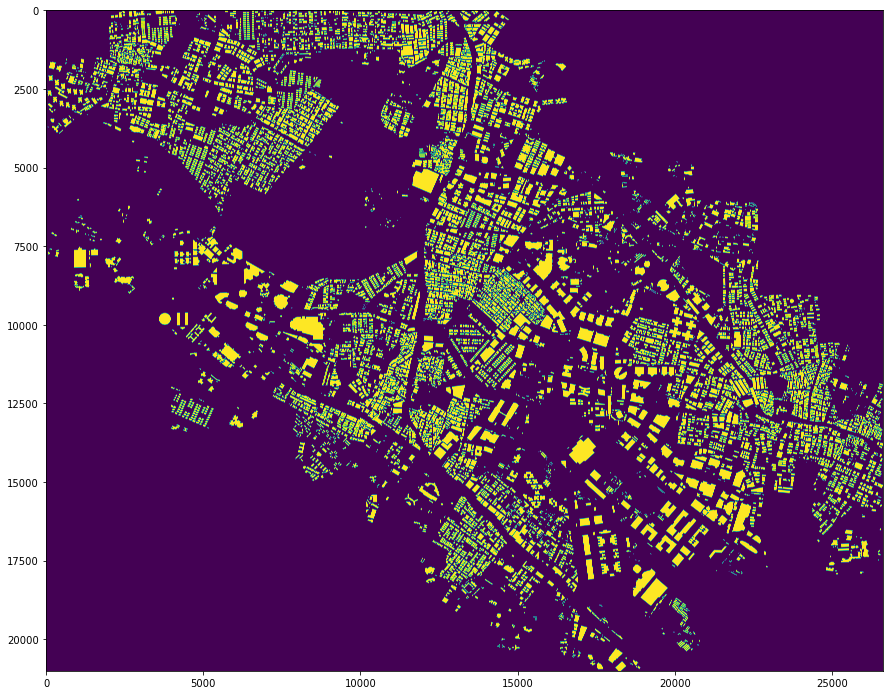

In [31]:
#Generate polygon
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # Convert polygons to the image CRS
        poly_pts.append(~transform * tuple(i))
        
    # Generate a polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# Generate Binary maks

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# Plot the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

mask = mask.astype("uint16")
save_path = 'D:\\Hyderabad_tiff\\mass_hyd\\mass_hyd_10.tif'
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open(save_path, 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)